## Import Library

In [ ]:
!pip install emoji
!pip install sentencepiece
!pip install nlpaug
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.4 MB/s eta 0:00:00


In [ ]:
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
import nltk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup
import nlpaug.augmenter.word as naw
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, BertModel , AdamW
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import random_split

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
df1 = pd.read_csv('27goemotions_no_multi_label_1.csv')
df2 = pd.read_csv('27goemotions_no_multi_label_2.csv')
df3 = pd.read_csv('27goemotions_no_multi_label_3.csv')
df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

## Balancing Data

In [ ]:
def balance_per_category(df, label_columns):
    balanced_data = []
    min_samples = df[label_columns].sum(axis=0).min()

    for label in label_columns:
        category_data = df[df[label] == 1]
        balanced_data.append(resample(category_data, n_samples=min_samples, random_state=42))

    return pd.concat(balanced_data).sample(frac=1, random_state=42)

df = balance_per_category(df, emotions)


In [ ]:
df = df.reset_index(drop=True)
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Love u too booboo,eeye7xk,agonizedn,COMPLETEANARCHY,t3_ajlhho,t1_eey9pmk,1.548445e+09,61,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Hey man. A lot of people have criminals in the...,eda09a2,WrongDetective,TrollXChromosomes,t3_acl29k,t1_ed9v7al,1.546662e+09,23,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"I'd say we are a role sub at best, sorry guys ...",eeqa1jf,Awportune,AtlantaHawks,t3_aiqxq7,t3_aiqxq7,1.548201e+09,24,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,"Sadly, he seems immune to bans. He also dodges...",ee6ewou,Landotavius,SeattleWA,t3_ag6l8w,t1_ee5xsma,1.547618e+09,5,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Fuck yea!,ee5g023,Jonger1150,PUBGXboxOne,t3_agbtrn,t3_agbtrn,1.547589e+09,20,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10872 entries, 0 to 10871
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  10872 non-null  object 
 1   id                    10872 non-null  object 
 2   author                10872 non-null  object 
 3   subreddit             10872 non-null  object 
 4   link_id               10872 non-null  object 
 5   parent_id             10872 non-null  object 
 6   created_utc           10872 non-null  float64
 7   rater_id              10872 non-null  int64  
 8   example_very_unclear  10872 non-null  bool   
 9   admiration            10872 non-null  int64  
 10  amusement             10872 non-null  int64  
 11  anger                 10872 non-null  int64  
 12  annoyance             10872 non-null  int64  
 13  approval              10872 non-null  int64  
 14  caring                10872 non-null  int64  
 15  confusion          

## Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df[emotions].copy()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

datasets = {
    "train_data.csv": pd.concat([X_train, y_train], axis=1),
    "val_data.csv": pd.concat([X_val, y_val], axis=1),
    "test_data.csv": pd.concat([X_test, y_test], axis=1),
}
output_folder = "/content/drive/MyDrive/emotion_detection"
for filename, df in datasets.items():
    df.to_csv(os.path.join(output_folder, filename), index=False)

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

df_train = pd.read_csv('/content/drive/MyDrive/emotion_detection/train_data.csv').reset_index(drop=True)

# Augment the text data
aug = naw.SynonymAug(aug_p=0.1)  # Augment 10% of the text
df_train['text'] = df_train['text'].apply(lambda x: aug.augment(x) if np.random.rand() < 0.1 else x)

df_val = pd.read_csv('/content/drive/MyDrive/emotion_detection/val_data.csv').reset_index(drop=True)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df_train.head()

,text,caring,love,gratitude,sadness,fear,anger
0,[I stockpile on an empty bellied. But I also c...,1,0,0,0,0,0
1,That's what I'm speaking purely about. We can ...,0,0,0,0,1,0
2,YOU KNOW HOW MUCH I SACRIFICED?,0,0,0,0,0,1
3,The double standard. Taking pictures of women ...,0,0,0,0,1,0
4,"I know you’re out there somewhere Beer Barron,...",0,0,0,0,0,1


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8697 entries, 0 to 8696
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8697 non-null   object
 1   caring     8697 non-null   int64 
 2   love       8697 non-null   int64 
 3   gratitude  8697 non-null   int64 
 4   sadness    8697 non-null   int64 
 5   fear       8697 non-null   int64 
 6   anger      8697 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 475.7+ KB


In [ ]:
df_train['sum'] = df_train.iloc[:,1:].sum(axis=1)
df_train['sum'].value_counts()

,count
sum,
1,8697


In [ ]:
df_val['sum'] = df_val.iloc[:,1:].sum(axis=1)
df_val['sum'].value_counts()

,count
sum,
1,1087


In [ ]:
df_val.head()

,text,caring,love,gratitude,sadness,fear,anger,sum
0,Probably. Government contracts are already ter...,0,0,0,0,1,0,1
1,poor little dude! Glad he's okay. He and his b...,0,0,0,1,0,0,1
2,That’s rude af. Slay him with your words. Give...,0,0,0,0,0,1,1
3,I guess but we love each other.,0,1,0,0,0,0,1
4,That was a fluid motion and it scared me,0,0,0,0,1,0,1


In [ ]:
df_train.drop(columns=['sum'], inplace=True)
df_val.drop(columns=['sum'], inplace=True)

## Clean Data

In [ ]:
def clean_text(text):
    text = str(text)  # Convert to string
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text


In [ ]:
df_train['text'] = df_train['text'].apply(clean_text)
df_val['text'] = df_val['text'].apply(clean_text)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Model

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8  # Reduced batch size
VALID_BATCH_SIZE = 8  # Reduced batch size
EPOCHS = 5
LEARNING_RATE = 5e-6
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = df['text'].values
        self.labels = df.iloc[:, 1:].values  # Assuming the first column is 'text' and the rest are labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenization
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)  # Use float for multi-label
        }

In [ ]:
# Create DataLoader
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
val_dataset = BERTDataset(df_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)


In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=6):  # Set dropout rate
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256) # Tambahkan layer fully connected 1
        self.fc2 = nn.Linear(256, num_classes) # Tambahkan layer fully connected 2

    def forward(self, input_ids, attention_mask): # Corrected indentation
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.fc1(pooled_output) # Tambahkan layer fully connected
        pooled_output = nn.ReLU()(pooled_output) # Tambahkan aktivasi ReLU
        return self.fc2(pooled_output)

model = BertClassifier().to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01) # AdamW dengan regularisasi L2
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        assert (labels == 0).sum() + (labels == 1).sum() == labels.numel(), "Labels should be binary (0 or 1)"

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Calculate loss using BCEWithLogitsLoss
        loss = criterion(outputs, labels)  # Use raw logits

        # Debugging: Print loss if it is NaN
        if torch.isnan(loss):
            print("NaN loss detected!")
            continue  # Skip this iteration if loss is NaN

        # Calculate predictions
        predictions = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions

        # Count correct predictions
        correct_predictions += (predicted_labels.eq(labels)).sum().item()

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Calculate average accuracy and loss
    average_accuracy = correct_predictions / (len(data_loader.dataset) * labels.size(1))
    average_loss = np.mean(losses)

    # Debugging: Ensure loss is non-negative
    if average_loss < 0:
        print("Warning: Negative average loss detected!")

    return average_accuracy, average_loss


In [ ]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            assert (labels == 0).sum() + (labels == 1).sum() == labels.numel(), "Labels should be binary (0 or 1)"

            outputs = model(input_ids, attention_mask)

            # Calculate loss using BCEWithLogitsLoss
            loss = criterion(outputs, labels)

            # Debugging: Print loss if it is NaN
            if torch.isnan(loss):
                print("NaN loss detected during evaluation!")
                continue  # Skip this iteration if loss is NaN

            # Get predictions
            predictions = torch.sigmoid(outputs)  # Apply sigmoid
            predicted_labels = (predictions > 0.5).float()  # Convert to binary predictions
            correct_predictions += (predicted_labels.eq(labels)).sum().item()
            losses.append(loss.item())

    average_accuracy = correct_predictions / (len(data_loader.dataset) * labels.size(1))
    average_loss = np.mean(losses)

    # Debugging: Ensure loss is non-negative
    if average_loss < 0:
        print("Warning: Negative average loss detected during evaluation!")

    return average_accuracy, average_loss

In [ ]:
import matplotlib.pyplot as plt
import pickle
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
for epoch in range(EPOCHS):
    print(f'Starting Epoch {epoch + 1}/{EPOCHS}', flush=True)

    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    val_acc, val_loss = eval_model(model, val_loader, device)

    # Step the scheduler
    optimizer.step()
    scheduler.step()  # Add this line

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print metrics for the current epoch
    print(f'Epoch {epoch + 1}/{EPOCHS} - '
          f'Train loss: {train_loss:.3f}, Train accuracy: {train_acc:.3f} - '
          f'Val loss: {val_loss:.3f}, Val accuracy: {val_acc:.3f}', flush=True)
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the model if it improves
        model_save_path = '/content/drive/MyDrive/emotion_detection/bert_model.pkl'  # Change path as needed
        with open(model_save_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved as {model_save_path}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Final save of the model
print("Training complete.")

Starting Epoch 1/5
Epoch 1/5 - Train loss: 0.473, Train accuracy: 0.819 - Val loss: 0.373, Val accuracy: 0.856
Model saved as /content/drive/MyDrive/emotion_detection/bert_model.pkl
Starting Epoch 2/5
Epoch 2/5 - Train loss: 0.316, Train accuracy: 0.885 - Val loss: 0.222, Val accuracy: 0.938
Model saved as /content/drive/MyDrive/emotion_detection/bert_model.pkl
Starting Epoch 3/5
Epoch 3/5 - Train loss: 0.218, Train accuracy: 0.934 - Val loss: 0.178, Val accuracy: 0.943
Model saved as /content/drive/MyDrive/emotion_detection/bert_model.pkl
Starting Epoch 4/5
Epoch 4/5 - Train loss: 0.172, Train accuracy: 0.948 - Val loss: 0.171, Val accuracy: 0.941
Model saved as /content/drive/MyDrive/emotion_detection/bert_model.pkl
Starting Epoch 5/5
Epoch 5/5 - Train loss: 0.142, Train accuracy: 0.958 - Val loss: 0.170, Val accuracy: 0.945
Model saved as /content/drive/MyDrive/emotion_detection/bert_model.pkl
Training complete.


In [ ]:
# Simpan model menggunakan torch.save
torch.save(model.state_dict(), '/content/drive/My Drive/bert_model.pth')

print(f"Model telah disimpan sebagai {model_save_path}")

Model telah disimpan sebagai /content/drive/MyDrive/emotion_detection/bert_model.pkl


In [ ]:
from sklearn.metrics import classification_report

all_predicted_classes = []
all_true_labels = []

# Iterate through the data loader
for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Get model outputs
    outputs = model(input_ids, attention_mask)

    # Apply sigmoid and get predicted classes
    predicted_probs = torch.sigmoid(outputs)
    predicted_classes = (predicted_probs > 0.5).cpu().numpy().astype(int)

    # Extend the lists with predictions and true labels
    all_predicted_classes.extend(predicted_classes)
    all_true_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays for easier manipulation
all_predicted_classes = np.array(all_predicted_classes)
all_true_labels = np.array(all_true_labels)

emotion_columns = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

# Print classification report
print(classification_report(all_true_labels, all_predicted_classes, target_names=emotion_columns, zero_division=0))
print(accuracy)

              precision    recall  f1-score   support

      caring       0.81      0.74      0.77       180
        love       0.91      0.90      0.91       175
   gratitude       0.93      0.89      0.91       185
     sadness       0.75      0.74      0.74       174
        fear       0.87      0.88      0.88       187
       anger       0.85      0.74      0.79       186

   micro avg       0.85      0.82      0.83      1087
   macro avg       0.85      0.82      0.83      1087
weighted avg       0.85      0.82      0.83      1087
 samples avg       0.82      0.82      0.82      1087

0.9473039215686274


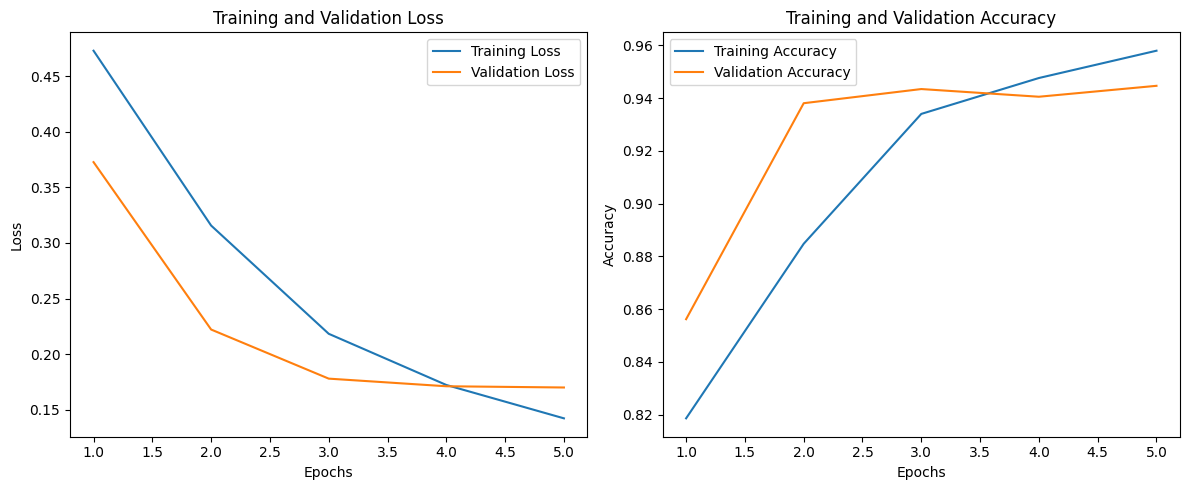

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
# Use the actual number of epochs for the x-axis
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
# Use the actual number of epochs for the x-axis
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Uji Coba

In [ ]:
from sklearn.metrics import f1_score
import pickle
#with open('/content/drive/MyDrive/bert_model1.pkl', 'rb') as f:
#    model = pickle.load(f)
model = BertClassifier() # Inisialisasi model dengan arsitektur yang sama
model.load_state_dict(torch.load('/content/drive/MyDrive/emotion_detection/bert_model1.pth'))
# Ensure model is in evaluation mode
model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to make predictions (with adjustable threshold)
def predict(text, threshold=0.6):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Explicitly set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Move input to the appropriate device
    inputs = {
        'input_ids': inputs['input_ids'].to(device),
        'attention_mask': inputs['attention_mask'].to(device)
    }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs
    probabilities = torch.sigmoid(logits)
    predicted_classes = (probabilities > threshold).int()

    return predicted_classes.cpu().numpy(), probabilities.cpu().numpy()

# Load data from CSV
test_dat = pd.read_csv('/content/drive/MyDrive/emotion_detection/test_data.csv')
emotion_columns = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

# Text preprocessing functions
def clean_text(text):
    text = str(text)
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def text_preprocessing_pipeline(text):
    return clean_text(text)

test_data = test_dat.copy()  # Create a copy to avoid modifying the original
test_data['text'] = test_data['text'].apply(text_preprocessing_pipeline)

# Variable to store predictions and true labels
predicted_classes = []
true_labels = test_data[emotion_columns].values

# Make predictions for each example in test data
for text in test_data['text']:
    predicted_class, _ = predict(text, threshold=0.6)  # Using threshold 0.6
    predicted_classes.append(predicted_class)

# Convert the list of predictions to a NumPy array before reshaping
predicted_classes = np.array(predicted_classes)
predicted_classes = predicted_classes.reshape(true_labels.shape)

# Calculate and print F1-Score
f1 = f1_score(true_labels, predicted_classes, average='micro')
print(f'F1-Score: {f1:.2f}')

# Calculate and print accuracy (optional)
accuracy = (predicted_classes == true_labels).mean()
print(f'Accuracy: {accuracy:.2f}')

F1-Score: 0.84
Accuracy: 0.95


In [ ]:
while True:
    text_input = input("Enter text to predict emotions (or type 'exit' to quit):  ")
    if text_input.lower() == 'exit':
        break

    # Preprocess the input text
    processed_text = text_preprocessing_pipeline(text_input)

    # Get predictions
    predicted_class, probabilities = predict(processed_text)

    # Print predicted emotions
    predicted_emotions = [emotion_columns[i] for i, val in enumerate(predicted_class[0]) if val == 1]
    print("Predicted Emotions:", predicted_emotions)


Enter text to predict emotions (or type 'exit' to quit):  Start your morning with enthusiasm and read a prayer
Predicted Emotions: ['caring']
Enter text to predict emotions (or type 'exit' to quit):  i hate everyone
Predicted Emotions: ['anger']
Enter text to predict emotions (or type 'exit' to quit):  Love is the gentle warmth that wraps your soul, the unspoken promise of forever, and the light that makes life endlessly beautiful
Predicted Emotions: ['love']
Enter text to predict emotions (or type 'exit' to quit):  exit
